In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import os
import pathos.multiprocessing
import itertools
from collections import Counter, OrderedDict
from string import ascii_lowercase, ascii_uppercase, digits
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

class Character:
    def __init__(self, possible_symbols, font):
        self.char = np.random.choice(possible_symbols, size=1)[0]
        self.x_size, self.y_size = draw.textsize(self.char, font=font)
        self.x, self.y = -1, -1
        
def _is_overlapping(x1_1, x1_2, y1_1, y1_2, x2_1, x2_2, y2_1, y2_2):
    if (x1_2 < x2_1) or (x1_1 > x2_2):
        return False
    if (y1_2 < y2_1) or (y1_1 > y2_2):
        return False
    return True

def is_overlapping(x, other_symbols):
    for i in other_symbols:
        if _is_overlapping(s.x, s.x + s.x_size, s.y, s.y + s.y_size,
                           i.x, i.x + i.x_size, i.y, i.y + i.y_size):
            return True
    return False

def draw_symbols(symbols, draw, font):
    for s in symbols:
        draw.text((s.x, s.y), s.char, font=font)
        #draw.rectangle(((s.x, s.y), (s.x + s.x_size, s.y + s.y_size)), outline="white")
    return draw

In [2]:
# we create a blank image first
# then we copy it and add some text
blank_filename = '123.png'
blank_image = Image.new('RGB', (224, 224))
blank_image.save(blank_filename, "PNG")
fontsize = 40
N_SYMBOLS = 2
N_FILES = 10000
font = ImageFont.truetype("./fonts/opensans/OpenSans-Regular.ttf", fontsize)
possible_symbols = list(['0', '1', '2'])
possible_symbols_dict = OrderedDict([(x, n + 1) for n, x in enumerate(possible_symbols)])
labels = {}

output_folder = './data/generated_ver_1/'
output_folder_images = os.path.join(output_folder, 'images/')
output_labels_filename = os.path.join(output_folder, 'labels.csv')
!rm -rf $output_folder
!mkdir -p $output_folder_images

In [3]:
# generate dataset:
for i in tqdm_notebook(range(N_FILES)):
    out_filename = '%0.8d.png' % i
    out_full_filename = os.path.join(output_folder_images, out_filename)
    source_img = Image.open(blank_filename).convert("RGB")
    draw = ImageDraw.Draw(source_img)
    N_SYMBOLS = 10
    raw_symbols = [Character(possible_symbols = possible_symbols, font = font) for _ in range(N_SYMBOLS)]
    
    symbols = []
    for s in raw_symbols:
        while True:
            s.x, s.y = np.random.randint(0, 224 - s.x_size), np.random.randint(0, 224 - s.y_size)
            if not is_overlapping(s, symbols):
                break
        symbols.append(s)
    
    labels[out_filename] = symbols
    draw_symbols(symbols, draw, font)
    source_img.save(out_full_filename, "PNG")

In [4]:
# generate labels for dataset
labels_for_df = [[(filename, s.x, s.x + s.x_size, 
                  s.y, s.y + s.y_size, possible_symbols_dict[s.char]) for s in many_symbols]
                                                                      for filename, many_symbols in labels.items()]
labels_df = pd.DataFrame(list(itertools.chain.from_iterable(labels_for_df)), 
                         columns = ['fname', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'])
display(labels_df.head(5))
labels_df.to_csv(output_labels_filename, index=None, sep=',')

,fname,xmin,xmax,ymin,ymax,class_id
0,00001178.png,50,73,174,217,3
1,00001178.png,102,125,122,165,1
2,00001178.png,122,145,179,222,1
3,00001178.png,145,168,129,172,1
4,00001178.png,195,218,62,105,1


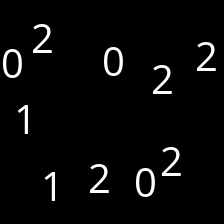

In [5]:
Image.open('./data/generated_ver_1/images/00000000.png')